# Tutorial: Meta-Learned Models of Cognition

## Data-Generating Distribution

Let $[x_1^i, x_2^i, \ldots, x_t^i, x_{t+1}^i]$ be a series of length measurements from species $i$.

We assume the following data-generating process:

$\begin{align}
    p(\mu,  x_{1:{t+1}}) &= p(x_{1:{t+1}} | \mu) p(\mu)  \\
    p(x_{1:{t+1}} | \mu) &= \prod_{k=1}^{t+1} p(x_{k} | \mu) = \prod_{k=1}^{t+1} \mathcal{N}(x_{k}; \mu, 1) \\
    p(\mu) &= \mathcal{N}(\mu; 0, 1)    
\end{align}$

## Bayesian Inference

With these assumptions the predictive posterior distribution has the following closed-form expression:

$\begin{align}
 p(x_{t+1} | x_{1:t}) &= \mathcal{N}(x_{t+1}; m, s) \\
 m &= \left( t + 1\right)^{-1}\sum_{k=1}^{t} x_k  \\
 s &= \sqrt{\left( t + 1\right)^{-1} + 1}
\end{align}$

In [1]:
def bayesian_inference(inputs):
    """ Performs Bayesian inference for the above data-generating process.
    Args:
        inputs: PyTorch Tensor of shape (num_observations, batch_size, 1)
        
    Returns:
        m: PyTorch Tensor of shape (batch_size, 1)
        s: Float
    """
    t = inputs.shape[0]
    m = 1/(t+1) * inputs.sum(0)
    s = math.sqrt((1 / (t+1)) + 1)
    return m, s

## Meta-Learning

We train a neural network to maximize the following equation:

\begin{equation} 
      \pmb{\Theta}^* \approx \text{arg}\max_{\pmb{\Theta}} \frac{1}{M}\sum  \log q_{\pmb{\Theta}}(x_{t+1} | x_{1:t})
\end{equation}

Meta-Learning Algorithm: 

1. Sample a batch of tasks from the data-generating distribution.
2. Pass the sequence of observations through the network and generate the approximate predictive posterior distribution.
3. Perform a gradient step on the above objective.
4. Repeat until convergence.

### 1. Sample a batch of tasks from the data-generating distribution.

torch.Size([16, 1])
torch.Size([7, 16, 1])


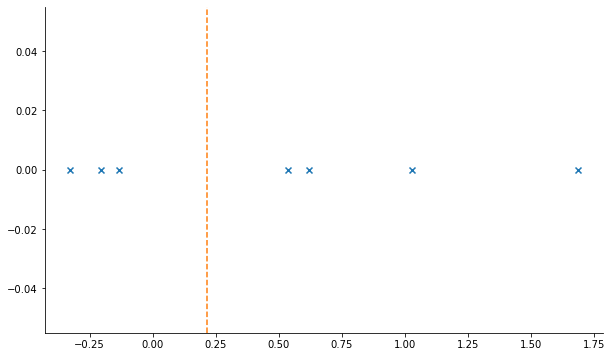

In [2]:
import math
import torch
from tqdm import tqdm
from torch.distributions import Normal
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)
batch_size = 16
seq_length = 7

# sample from the prior
mu = Normal(torch.zeros(1), 1).sample((batch_size,))
print(mu.shape)

# sample from the likelihood
x_test = Normal(mu, 1).sample((seq_length,))
print(x_test.shape)

# plot the data
plt.scatter(x_test[:, 0, 0], torch.zeros(seq_length), marker='x')
plt.axvline(mu[0, 0], color='C1', ls='--')
sns.despine()

### 2. Pass the sequence of observations through the network and generate the approximate predictive posterior distribution.

<img src="rnn.png">

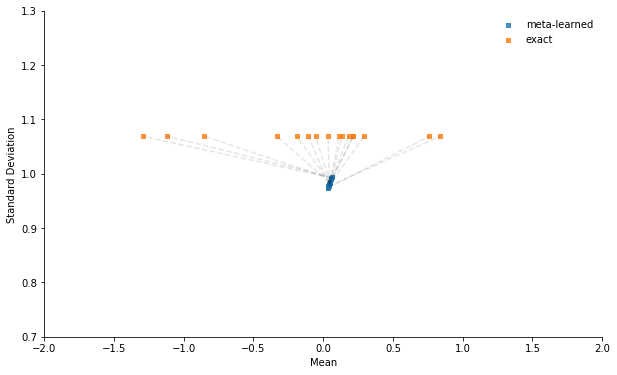

In [3]:
class MetaLearner(torch.nn.Module):
    def __init__(self, num_hidden=256):
        super(MetaLearner, self).__init__()
        
        self.rnn = torch.nn.LSTM(1, num_hidden)
        self.linear_mu = torch.nn.Linear(num_hidden, 1)
        self.linear_logstd = torch.nn.Linear(num_hidden, 1)

    def forward(self, inputs):
        """
        Args:
            inputs (Tensor): PyTorch tensor of size (seq_length, batch_size, 1)
        
        Returns:
            Normal object: Normal distribution object with dimensions (batch_size, 1)
        """
        hidden, _ = self.rnn(inputs)
        hidden = hidden[-1]
        
        mu = self.linear_mu(hidden)
        std = torch.exp(self.linear_logstd(hidden))
        
        return Normal(mu, std)

# infer the predictive posterior using the untrained algorithm
network = MetaLearner()
predictive_posterior = network(x_test[:seq_length-1])

# infer the predictive posterior using exact Bayesian inference
m, s = bayesian_inference(x_test[:seq_length-1])

  
# plot the results
with torch.no_grad():
    plt.scatter(predictive_posterior.loc.squeeze(), predictive_posterior.scale.squeeze(), alpha=0.8, marker='s', s=10)
    plt.scatter(m.squeeze(), torch.ones(batch_size) * s, alpha=0.8, marker='s', s=10, color='C1')
    
    plt.legend(['meta-learned', 'exact'], frameon=False)
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
    
    X = torch.stack((predictive_posterior.loc[:, 0], m[:, 0]))
    Y = torch.stack((predictive_posterior.scale[:, 0], torch.ones(batch_size) * s))

    plt.plot(X.detach(),
             Y.detach(),
             color='black', alpha=0.1, ls='--')

    sns.despine()
    plt.xlim(-2, 2)
    plt.ylim(0.7, 1.3)

### 3. Perform a gradient step on the above objective.

In [4]:
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)

loss = -predictive_posterior.log_prob(x_test[-1]).mean()

optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(network.parameters(), 40.0)
optimizer.step()

### 4. Repeat until convergence.

In [5]:
class MetaLearner(torch.nn.Module):
    def __init__(self, num_hidden=256):
        super(MetaLearner, self).__init__()
        
        self.rnn = torch.nn.LSTM(1, num_hidden)
        self.linear_mu = torch.nn.Linear(num_hidden, 1)
        self.linear_logstd = torch.nn.Linear(num_hidden, 1)

    def forward(self, inputs):
        """
        Args:
            inputs (Tensor): PyTorch tensor of size (seq_length, batch_size, 1)
        
        Returns:
            Normal object: Normal distribution object with dimensions (batch_size, 1)
        """
        hidden, _ = self.rnn(inputs)
        hidden = hidden[-1]
        
        mu = self.linear_mu(hidden)
        std = torch.exp(self.linear_logstd(hidden))
        
        return Normal(mu, std)

iterations = 100000
batch_size = 16
seq_length = 7

network = MetaLearner()
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9999)

# 4. Repeat until convergence.
for t in tqdm(range(iterations)):
    
    # 1. Sample a batch of tasks from the data-generating distribution.
    mu = Normal(torch.zeros(1), 1).sample((batch_size,))
    x = Normal(mu, 1).sample((seq_length,))
    
    # 2. Pass the sequence of observations through the network and generate the approximate predictive posterior distribution.
    predictive_posterior = network(x[:seq_length-1])
    
    # 3. Perform a gradient step on the above objective.
    loss = -predictive_posterior.log_prob(x[-1]).mean()
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(network.parameters(), 40.0)
    optimizer.step()
    scheduler.step()

100%|██████████████████████████████████| 100000/100000 [13:31<00:00, 123.29it/s]


### Testing the meta-learned algorithm

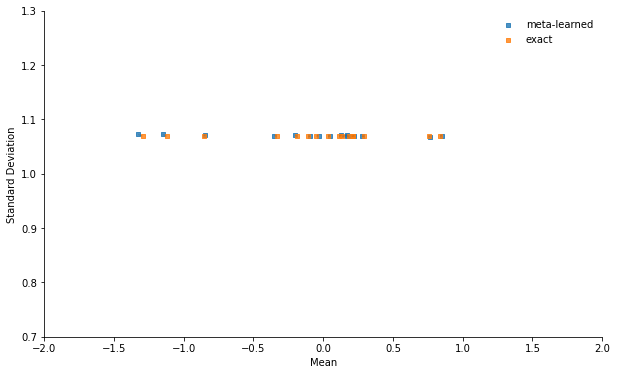

In [10]:
# infer the predictive posterior using the meta-learned algorithm
predictive_posterior = network(x_test[:seq_length-1])

# infer the predictive posterior using exact Bayesian inference
m, s = bayesian_inference(x_test[:seq_length-1])

# plot the results
with torch.no_grad():
    plt.scatter(predictive_posterior.loc.squeeze(), predictive_posterior.scale.squeeze(), alpha=0.8, marker='s', s=10)
    plt.scatter(m.squeeze(), torch.ones(batch_size) * s, alpha=0.8, marker='s', s=10, color='C1')
    
    plt.legend(['meta-learned', 'exact'], frameon=False)
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
    
    X = torch.stack((predictive_posterior.loc[:, 0], m[:, 0]))
    Y = torch.stack((predictive_posterior.scale[:, 0], torch.ones(batch_size) * s))

    plt.plot(X.detach(),
             Y.detach(),
             color='black', alpha=0.1, ls='--')

    sns.despine()
    plt.xlim(-2, 2)
    plt.ylim(0.7, 1.3)
    plt.savefig('after.pdf')